# Trains

In [2]:
pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 36.9 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [contextily]9 [geopy]io]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import json
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [4]:
fichier_json = 'gares-de-voyageurs.geojson'


with open(fichier_json, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. Transformation en tableau Pandas
# On cible la clé 'features' qui contient la liste des gares
df = pd.json_normalize(data['features'])

# 3. Nettoyage des colonnes
# Les colonnes s'appellent "properties.nom", "geometry.coordinates", etc.
# On va simplifier les noms
df.columns = [c.replace('properties.', '').replace('geometry.', '') for c in df.columns]

# 4. Séparation de la latitude et longitude
# La colonne 'coordinates' est une liste [Lon, Lat]. On la divise en deux.
# Attention : GeoJSON met la Longitude en premier !
df['longitude'] = df['coordinates'].apply(lambda x: x[0] if isinstance(x, list) else None)
df['latitude'] = df['coordinates'].apply(lambda x: x[1] if isinstance(x, list) else None)

# 5. Sélection et renommage final
# On garde ce qui vous intéresse pour votre modèle immo
colonnes_utiles = [
    'nom', 
    'codeinsee', 
    'latitude', 
    'longitude', 
    'segment_drg' # Info utile: A = Grosse gare TGV, C = Petite gare
    ]
    
# On filtre pour ne garder que les colonnes existantes
colonnes_finales = [c for c in colonnes_utiles if c in df.columns]
df_clean = df[colonnes_finales]

print(f"{len(df_clean)} gares récupérées.")
print(df_clean.head())

# 6. Export en CSV pour utilisation future
df_clean.to_csv("gares_sncf_final.csv", index=False)

2785 gares récupérées.
                     nom codeinsee   latitude  longitude segment_drg
0              Abancourt     60001  49.685224   1.774306           C
1               Abbaretz     44001  47.554643  -1.524416           C
2              Abbeville     80001  50.102210   1.824490           B
3        Ablon-sur-Seine     94001  48.725468   2.419151           B
4  Achères Grand Cormier     78551  48.955183   2.091903           B


In [5]:
wesh = pd.read_csv("gares_sncf_final.csv")
wesh.head()

,nom,codeinsee,latitude,longitude,segment_drg
0,Abancourt,60001,49.685224,1.774306,C
1,Abbaretz,44001,47.554643,-1.524416,C
2,Abbeville,80001,50.102210,1.824490,B
3,Ablon-sur-Seine,94001,48.725468,2.419151,B
4,Achères Grand Cormier,78551,48.955183,2.091903,B


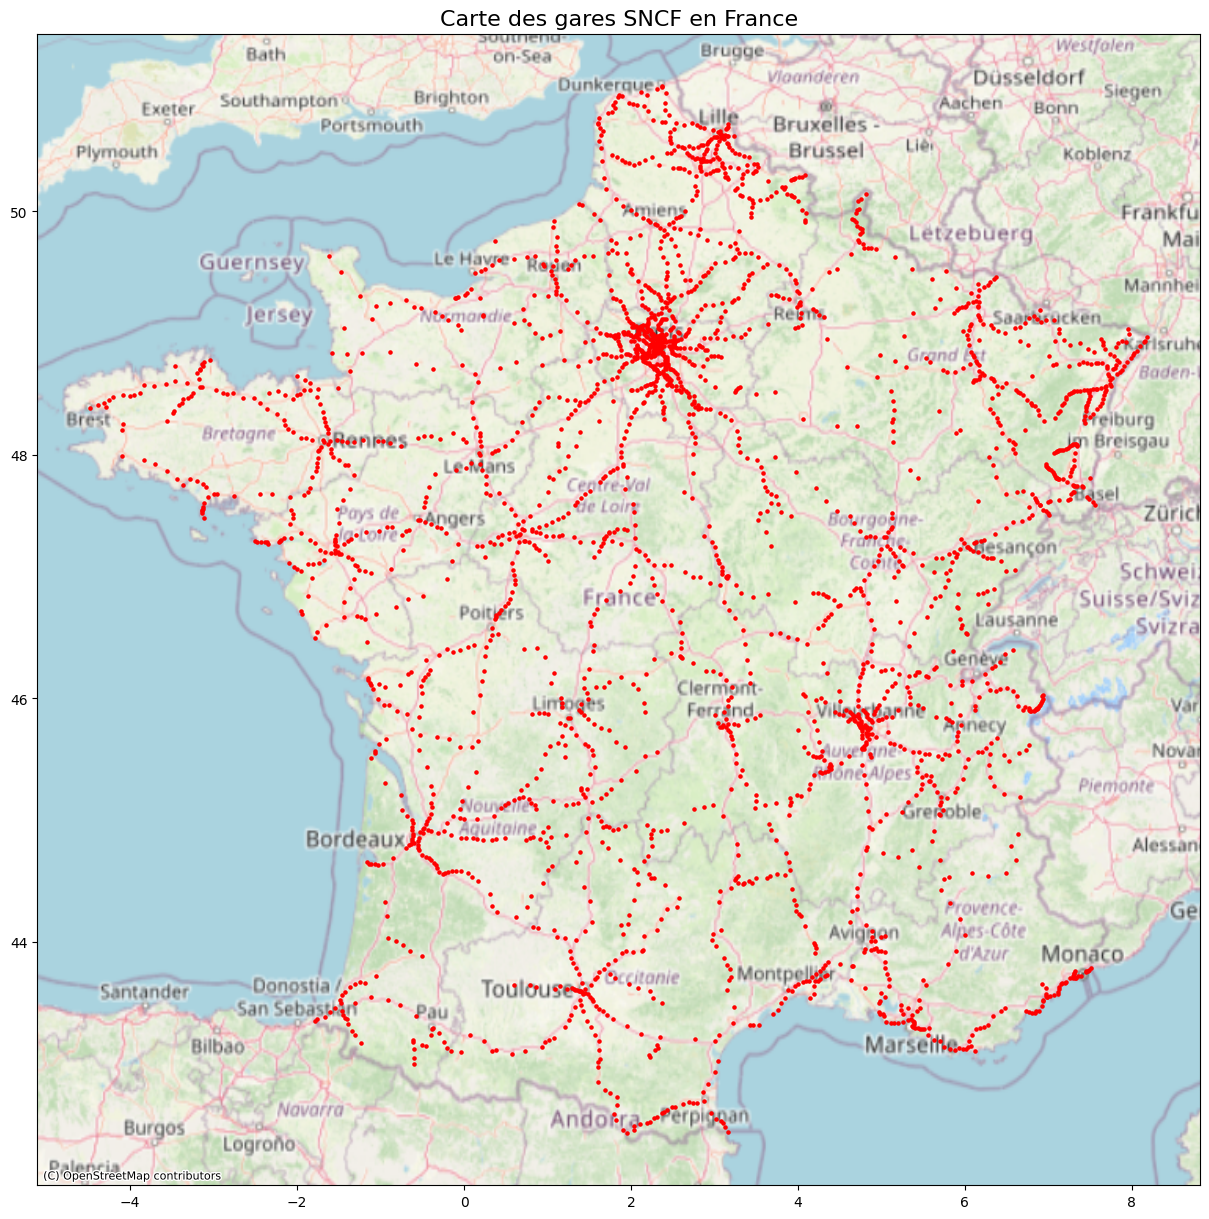

In [6]:
# 2. Convertir le DataFrame des gares en GeoDataFrame
gdf_gares = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean['longitude'], df_clean['latitude']),
    crs="EPSG:4326"  # Système de coordonnées WGS84
)

# 3. Afficher la carte avec un fond de carte OpenStreetMap
fig, ax = plt.subplots(figsize=(15, 15))

# Tracer les gares (en rouge)
gdf_gares.plot(ax=ax, color='red', markersize=5, label='Gares SNCF')

# Ajouter un fond de carte (OpenStreetMap)
ctx.add_basemap(ax, crs=gdf_gares.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Ajouter un titre et une légende
plt.title("Carte des gares SNCF en France", fontsize=16)

# Afficher la carte
plt.show()